In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/MyDrive/assignment5/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/assignment5/" $datadir
os.chdir(datadir)
!pwd

/content/drive/MyDrive/assignment5


# Deep Q-Learning

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [ ]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [ ]:

!pip3 install --upgrade setuptools --user
!pip3 install ez_setup
!pip3 install gym[atari]
!pip3 install gym[accept-rom-license]

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [ ]:
# Hyperparameters for DQN agent, memory and training
EPISODES = 3500
HEIGHT = 84
WIDTH = 84
HISTORY_SIZE = 4
learning_rate = 0.0001
evaluation_reward_length = 100
Memory_capacity = 1000000
train_frame = 100000 # You can set it to a lower value while testing your code so you don't have to wait longer to see if the training code does not have any syntax errors
batch_size = 128
scheduler_gamma = 0.4
scheduler_step_size = 100000

# Hyperparameters for Double DQN agent
update_target_network_frequency = 1000

# Hyperparameters for DQN LSTM agent
lstm_seq_length = 5

In [ ]:
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
# from config import *

def find_max_lives(env):
    env.reset()
    _, _, _, info = env.step(0)
    return info['lives']

def check_live(life, cur_life):
    if life > cur_life:
        return True
    else:
        return False

def get_frame(X):
    x = np.uint8(resize(rgb2gray(X), (HEIGHT, WIDTH), mode='reflect') * 255)
    return x

def get_init_state(history, s, history_size):
    for i in range(history_size):
        history[i, :, :] = get_frame(s)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# from config import HEIGHT, WIDTH, lstm_seq_length

class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(3136, 512)
        self.head = nn.Linear(512, action_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        return self.head(x)


# class DQN_LSTM(nn.Module):
#     def __init__(self, action_size):
#         super(DQN_LSTM, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.fc = nn.Linear(3136, 512)
#         self.head = nn.Linear(256, action_size)
#         self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)

#     def forward(self, x, hidden=None, train=True):
#         if train:  # If training, we will merge all the visual states into one.
#             x = x.view(-1, 1, HEIGHT, WIDTH)
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.relu(self.fc(x.view(x.size(0), -1)))
#         if train:  # We will reshape the output to match the original shape.
#             x = x.view(-1, lstm_seq_length, 512)
#             lstm_output, hidden = self.lstm(x, hidden)
#             x = lstm_output[:, -1, :]
#         return self.head(x), hidden

In [ ]:
# from config import *
from collections import deque
import numpy as np
import random


class ReplayMemory(object):
    def __init__(self):
        self.memory = deque(maxlen=Memory_capacity)

    def push(self, history, action, reward, done):
        self.memory.append((history, action, reward, done))

    def sample_mini_batch(self, frame):
        mini_batch = []
        if frame >= Memory_capacity:
            sample_range = Memory_capacity
        else:
            sample_range = frame

        # history size
        sample_range -= (HISTORY_SIZE + 1)

        idx_sample = random.sample(range(sample_range), batch_size)
        for i in idx_sample:
            sample = []
            for j in range(HISTORY_SIZE + 1):
                sample.append(self.memory[i + j])

            sample = np.array(sample, dtype=object)
            mini_batch.append((np.stack(sample[:, 0], axis=0), sample[3, 1], sample[3, 2], sample[3, 3]))

        return mini_batch

    def __len__(self):
        return len(self.memory)


class ReplayMemoryLSTM(ReplayMemory):
    """
    This is a version of Replay Memory modified for LSTMs.
    Replay memory generally stores (state, action, reward, next state).
    But LSTMs need sequential data.
    So we store (state, action, reward, next state) for previous few states, constituting a trajectory.
    During training, the previous states will be used to generate the current state of LSTM.
    Note that samples from previous episode might get included in the trajectory.
    Inspite of not being fully correct, this simple Replay Buffer performs well.
    """
    def __init__(self):
        super().__init__()

    def sample_mini_batch(self, frame):
        mini_batch = []
        if frame >= Memory_capacity:
            sample_range = Memory_capacity
        else:
            sample_range = frame

        sample_range -= (lstm_seq_length + 1)

        idx_sample = random.sample(range(sample_range - lstm_seq_length), batch_size)
        for i in idx_sample:
            sample = []
            for j in range(lstm_seq_length + 1):
                sample.append(self.memory[i + j])

            sample = np.array(sample, dtype=object)
            mini_batch.append((np.stack(sample[:, 0], axis=0), sample[lstm_seq_length - 1, 1], sample[lstm_seq_length - 1, 2], sample[lstm_seq_length - 1, 3]))

        return mini_batch

In [ ]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from utils import find_max_lives, check_live, get_frame, get_init_state
# from model import DQN, DQN_LSTM
# from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs.

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [ ]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [ ]:
import random
import torch
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from memory import ReplayMemory, ReplayMemoryLSTM
# from model import DQN, DQN_LSTM
# from utils import find_max_lives, check_live, get_frame, get_init_state
# from config import *
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, action_size):
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.explore_step = 500000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.train_start = 100000
        self.update_target = 1000

        # Generate the memory
        self.memory = ReplayMemory()

        # Create the policy net
        self.policy_net = DQN(action_size)
        self.policy_net.to(device)

        self.optimizer = optim.Adam(params=self.policy_net.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    def load_policy_net(self, path):
        self.policy_net = torch.load(path)

    """Get action using policy net using epsilon-greedy policy"""
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
           return torch.tensor([random.randrange(self.action_size)], device=device)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.max(1)[1].view(1, 1)

    # pick samples randomly from replay memory (with batch_size)
    def train_policy_net(self, frame):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch = self.memory.sample_mini_batch(frame)
        mini_batch = np.array(mini_batch, dtype=object).transpose()

        history = np.stack(mini_batch[0], axis=0)
        states = np.float32(history[:, :4, :, :]) / 255.
        states = torch.from_numpy(states).cuda()
        actions = list(mini_batch[1])
        actions = torch.LongTensor(actions).cuda()
        rewards = list(mini_batch[2])
        rewards = torch.FloatTensor(rewards).cuda()
        next_states = np.float32(history[:, 1:, :, :]) / 255.
        dones = mini_batch[3] # checks if the game is over
        mask = torch.tensor(list(map(int, dones==False)),dtype=torch.uint8).to(device)



        q_vals = self.policy_net(states).gather(1, actions.unsqueeze(1))

        next_state =torch.tensor(next_states).to(device)
        next_q_vals = self.policy_net(next_state).detach().max(1)[0]


        expected = rewards + (self.discount_factor * next_q_vals * mask.float())


        loss = F.smooth_l1_loss(q_vals, expected.unsqueeze(1))


        # q_vals = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # next_state_values = torch.zeros(len(mini_batch), device=device).cuda()
        # non_final_mask = mask == False
        # non_final_next_states = next_states[non_final_mask]
        # if len(non_final_next_states) > 0:
        #     non_final_next_state_values = self.policy_net(non_final_next_states).max(1)[0].detach()
        #     next_state_values[non_final_mask] = non_final_next_state_values



        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()


In [ ]:
import random
import torch
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from memory import ReplayMemory
# from model import DQN
# from utils import find_max_lives, check_live, get_frame, get_init_state
# from config import *
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DoubleAgent():
    def __init__(self, action_size):
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.explore_step = 500000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.train_start = 100000
        self.update_target = 1000

        # Generate the memory
        self.memory = ReplayMemory()

        # Create the policy net and the target net
        self.policy_net = DQN(action_size)
        self.policy_net.to(device)

        self.optimizer = optim.Adam(params=self.policy_net.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        # Initialize a target network and initialize the target network to the policy net
        self.target_net = DQN(action_size).to(device)
        self.target_net.eval()
        self.update_target_net()


    def load_policy_net(self, path):
        self.policy_net = torch.load(path)

    # after some time interval update the target net to be same with policy net
    def update_target_net(self):
          self.target_net.load_state_dict(self.policy_net.state_dict())


    """Get action using policy net using epsilon-greedy policy"""
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
           return random.randrange(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            # state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            return self.policy_net(state).max(1)[1].item()
            # with torch.no_grad():
            #     q_values = self.policy_net(state)

    # pick samples randomly from replay memory (with batch_size)
    def train_policy_net(self, frame):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch = self.memory.sample_mini_batch(frame)
        mini_batch = np.array(mini_batch, dtype=object).transpose()

        history = np.stack(mini_batch[0], axis=0)
        states = np.float32(history[:, :4, :, :]) / 255.
        states = torch.from_numpy(states).cuda()
        actions = list(mini_batch[1])
        actions = torch.LongTensor(actions).cuda()
        rewards = list(mini_batch[2])
        rewards = torch.FloatTensor(rewards).cuda()
        next_states = np.float32(history[:, 1:, :, :]) / 255.
        dones = mini_batch[3] # checks if the game is over
        mask = torch.tensor(list(map(int, dones==False)),dtype=torch.uint8).to(device)


        q_vals = self.policy_net(states).gather(1, actions.unsqueeze(1))

        next_state =torch.tensor(next_states).to(device)
        next_q_vals = self.policy_net(next_state).detach().max(1)[1]

        next_actions = self.target_policy_net(next_state).detach()


        next_s_vals = next_actions.gather(1, next_q_vals.unsqueeze(1)).squeeze(1) * mask.float()
        expected = rewards + self.discount_factor*next_s_vals

        loss = F.smooth_l1_loss(q_vals, expected.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)
        self.optimizer.step()
        self.scheduler.step()

In [ ]:
double_dqn = False # set to True if using double DQN agent

if double_dqn:
    agent = DoubleAgent(action_size)
else:
    agent = Agent(action_size)

# agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

episode: 0   score: 2.0   memory length: 198   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 2.0
episode: 1   score: 0.0   memory length: 322   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 1.0
episode: 2   score: 2.0   memory length: 541   epsilon: 1.0    steps: 219    lr: 0.0001     evaluation reward: 1.3333333333333333
episode: 3   score: 2.0   memory length: 740   epsilon: 1.0    steps: 199    lr: 0.0001     evaluation reward: 1.5
episode: 4   score: 3.0   memory length: 1007   epsilon: 1.0    steps: 267    lr: 0.0001     evaluation reward: 1.8
episode: 5   score: 0.0   memory length: 1130   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.5
episode: 6   score: 3.0   memory length: 1399   epsilon: 1.0    steps: 269    lr: 0.0001     evaluation reward: 1.7142857142857142
episode: 7   score: 2.0   memory length: 1597   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 1.75
episode: 8   score: 1.0   memory length: 1748

KeyboardInterrupt: 

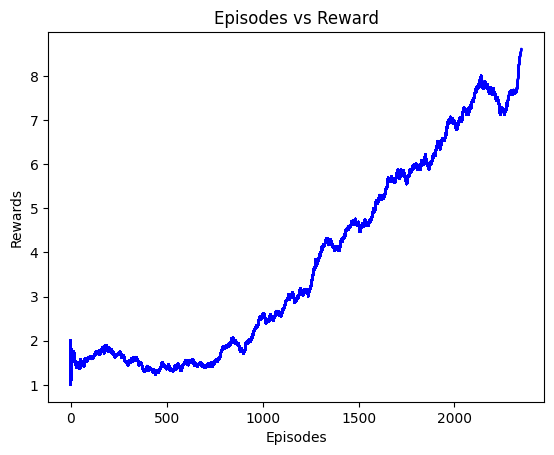

In [31]:
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = torch.tensor([[0]]).cuda()
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, done, info = env.step(action + 1)

        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory
        agent.memory.push(deepcopy(frame_next_state), action.cpu(), r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame): # You can set train_frame to a lower value while testing your starts training earlier
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]

        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards')
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn.png") # save graph for training visualization

            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [32]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_latest.pth")

In [33]:
!sudo apt-get install xvfb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [36]:
from gym.wrappers import RecordVideo # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video')
    return env

In [40]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
agent.load_policy_net("./save_model/breakout_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)

while not done:

    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state

    next_state, reward, done, info = env.step(action + 1)

    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['lives'])

    life = info['lives']
    r = np.clip(reward, -1, 1)
    r = reward

    # Store the transition in memory
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward

    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/assignment5/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Rec